**Kelompok 1 - 2024A:**
1.   Aulia Aziza (24031554102)
2.   Siti Aisyah Febriyanti (24031554158)



# DATASET

In [1]:
!pip install gdown #agar bisa mendownload file dari drive

In [3]:
import os #manipulasi file dan folder
import zipfile #ekstrak zip
import gdown

FILE_ID = "1XqpFZjyZYJQjrZdZH6v9AcubBtbW5cc7" #id folder dataset di drive
DATASET_DIR = "data/audio-gender" #lokasi folder dataset yang telah diekstraksi
ZIP_PATH = "data/audio-gender.zip" #path file zip

os.makedirs("data", exist_ok=True)

if not os.path.exists(DATASET_DIR): #mencek apakah dataset sudah terdownload agar tidak double
    print("Downloading dataset...")
    url = f"https://drive.google.com/uc?id={FILE_ID}"
    gdown.download(url, ZIP_PATH, quiet=False)

    print("Extracting...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as z: #ekstrak isi zip ke folder data
        z.extractall("data")

    os.remove(ZIP_PATH)

print("Dataset ready ")

Downloading...
From: https://drive.google.com/uc?id=1XqpFZjyZYJQjrZdZH6v9AcubBtbW5cc7
To: /content/data/audio-gender.zip
100%|██████████| 15.9M/15.9M [00:01<00:00, 14.2MB/s]


Extracting...
Dataset ready 


In [4]:
def print_dir_tree(path): #cek struktur zip yang terdownload untuk memastikan isi zip yang terdownload sudah benar
    for root, dirs, files in os.walk(path):
        level = root.replace(path, "").count(os.sep)
        indent = " " * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        for f in files:
            print(f"{indent}    {f}")

In [5]:
print("\nSTRUKTUR DATASET")
print_dir_tree("data")


STRUKTUR DATASET
data/
    audio-gender/
        female/
            FPTOpenSpeechData_Set001_V0.1_000061.wav
            FPTOpenSpeechData_Set001_V0.1_000065.wav
            FPTOpenSpeechData_Set001_V0.1_000037.wav
            FPTOpenSpeechData_Set001_V0.1_000039.wav
            FPTOpenSpeechData_Set001_V0.1_000062.wav
            FPTOpenSpeechData_Set001_V0.1_000041.wav
            FPTOpenSpeechData_Set001_V0.1_000038.wav
            FPTOpenSpeechData_Set001_V0.1_000035.wav
            FPTOpenSpeechData_Set001_V0.1_000067.wav
            FPTOpenSpeechData_Set001_V0.1_000076.wav
            FPTOpenSpeechData_Set001_V0.1_000034.wav
            FPTOpenSpeechData_Set001_V0.1_000082.wav
            FPTOpenSpeechData_Set001_V0.1_000058.wav
            FPTOpenSpeechData_Set001_V0.1_000033.wav
            FPTOpenSpeechData_Set001_V0.1_000044.wav
            FPTOpenSpeechData_Set001_V0.1_000083.wav
            FPTOpenSpeechData_Set001_V0.1_000048.wav
            FPTOpenSpeechData_Set001_V0.1

# Import Library & Parameter

In [6]:
import os
import numpy as np
import librosa #untuk memproses audio
from scipy.signal import firwin, lfilter #filter fir
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [7]:
DATASET_PATH = "data/audio-gender"
WINDOW_LIST = ["rectangular", "hamming", "hann", "blackman"] #window yang digunakan dalam fungsi fft
RANDOM_STATE = 42
SNR_NOISE = 20 #untuk gaussian noise ditambahkan 20dB

In [8]:
SR_TARGET = None #sample rate audio dipertahankan aja
N_FFT = 1024 #ukuran FFT
HOP_LENGTH = 512
WIN_LENGTH = 1024 #panjang window

# Preprocessing WAV

In [9]:
def normalize_audio(y): #normalisasi amplitudo di rentang -1 sampai 1
    return y if np.max(np.abs(y)) == 0 else y / np.max(np.abs(y))

In [10]:
def add_gaussian_noise(y, snr_db): #penambahan gaussian noise
    sig_power = np.mean(y ** 2) #daya sinyal
    snr_linear = 10 ** (snr_db / 10) #konversi snr ke linear
    noise_power = sig_power / snr_linear #menghitung daya noise
    noise = np.random.normal(0, np.sqrt(noise_power), len(y))
    return y + noise

In [11]:
def apply_fir_bandpass(y, sr, lowcut=80, highcut=3400, numtaps=101, window_type="hann"): #fir bandpass filter dengan cutoff 80-3400Hz
    nyq = sr / 2 #frekuensi nyquist
    taps = firwin(
        numtaps,
        [lowcut/nyq, highcut/nyq],
        pass_zero=False,
        window=window_type
    )
    return lfilter(taps, 1.0, y) #menerapkan ke sinyal

# Feature Extraction

In [12]:
def extract_features(y, sr, window_type): #ekstraksi domain frekuensi
    if window_type == "rectangular":
        window = np.ones(WIN_LENGTH)
    elif window_type == "hamming":
        window = np.hamming(WIN_LENGTH)
    elif window_type == "hann":
        window = np.hanning(WIN_LENGTH)
    else:
        window = np.blackman(WIN_LENGTH)

    S = np.abs(librosa.stft(
        y,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        win_length=WIN_LENGTH,
        window=window
    )) #mengubah sinyal waktu ke domain frekuensi

    S = S / (np.sum(S) + 1e-12) #normalisasi spektrum

    feats = [
        np.mean(S),
        np.std(S),
        np.max(S),
        np.median(S),
        np.percentile(S, 75),
        np.percentile(S, 25)
    ] #statistik spektrum

    cent = librosa.feature.spectral_centroid(S=S, sr=sr) #spectral centroid brightness
    bw = librosa.feature.spectral_bandwidth(S=S, sr=sr) #spectral bandwidht, lebar spektrum
    feats += [np.mean(cent), np.mean(bw)] #tambahan fitur ke vektor

    return np.array(feats)

# Load Data

In [13]:
def load_files(dataset_path): #membaca file audio dan labelnya
    files, labels = [], []
    for label in os.listdir(dataset_path):
        path = os.path.join(dataset_path, label)
        if not os.path.isdir(path): continue
        for f in os.listdir(path):
            if f.endswith(".wav"):
                files.append(os.path.join(path, f))
                labels.append(0 if label == "male" else 1) #label male=0, female=1
    return files, np.array(labels)

files, labels = load_files(DATASET_PATH)

# Training & Evaluasi Model

In [14]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
) #mengimpor fungsi untuk menghitung akurasi model

def evaluate_model(y_true, y_pred): #fungsi evaluasi model
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "confusion_matrix": confusion_matrix(y_true, y_pred),
        "classification_report": classification_report(
            y_true, y_pred,
            target_names=["male", "female"],
            zero_division=0
        )
    }
    return metrics

Model Clean

In [21]:
results_clean = [] #untuk menyimpan hasil clean tiap window

for window in WINDOW_LIST: #loop untuk seluruh jenis window
    X, y = [], []

    for fp, lbl in zip(files, labels): #loop file dan audionya
        y_sig, sr = librosa.load(fp, sr=SR_TARGET) #file audio dan sampling rate
        y_sig = normalize_audio(y_sig) #normalisasi amplitudo
        y_sig = apply_fir_bandpass(y_sig, sr, window_type=window) #filtering sinyal menggunakan fir bandpass dengan window twrtentu

        feat = extract_features(y_sig, sr, window) #ekstraksi fitur berbasis stft/fft
        X.append(feat)
        y.append(lbl)

    X = np.vstack(X) #mengubah list fitur menjadi array 2 dimensi
    y = np.array(y) #mengubah label menjadi array numpy

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
    ) #splittiing data 70% data training dan 30%data uji

    clf = SVC(kernel="rbf") #membuat model svm dengan kernel rbf
    clf.fit(X_train, y_train) #melatih model
    y_pred = clf.predict(X_test) #melakukan prediksi

    results_clean.append({
        "window": window,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred)
    }) #menyimpan hasil evaluasi ringkas

df_clean = pd.DataFrame(results_clean) #membuat dataframe dari hasil clean

In [22]:
evaluation_clean = {} #dictionary untuk menyimpan hasil evaluasi clean untuk setiap jenis window

for window in WINDOW_LIST: #loop untuk memproses setiap jenis window
    X, y = [], []

    for fp, lbl in zip(files, labels):
        sig, sr = librosa.load(fp, sr=SR_TARGET)
        sig = normalize_audio(sig)
        sig = apply_fir_bandpass(sig, sr, window_type=window)

        feat = extract_features(sig, sr, window)
        X.append(feat)
        y.append(lbl)

    X = np.vstack(X)
    y = np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.3,
        stratify=y,
        random_state=RANDOM_STATE
    )

    clf = SVC(kernel="rbf")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    evaluation_clean[window] = evaluate_model(y_test, y_pred) #menghitung dan menyimpan metrik evaluasi (accuracy, precision, recall, f1, confusion matrix)

    print(f"\nCLEAN | Window: {window}")
    print(evaluation_clean[window]["classification_report"])
    print("Confusion Matrix:")
    print(evaluation_clean[window]["confusion_matrix"])


CLEAN | Window: rectangular
              precision    recall  f1-score   support

        male       0.75      0.67      0.71         9
      female       0.70      0.78      0.74         9

    accuracy                           0.72        18
   macro avg       0.72      0.72      0.72        18
weighted avg       0.73      0.72      0.72        18

Confusion Matrix:
[[6 3]
 [2 7]]

CLEAN | Window: hamming
              precision    recall  f1-score   support

        male       0.83      0.56      0.67         9
      female       0.67      0.89      0.76         9

    accuracy                           0.72        18
   macro avg       0.75      0.72      0.71        18
weighted avg       0.75      0.72      0.71        18

Confusion Matrix:
[[5 4]
 [1 8]]

CLEAN | Window: hann
              precision    recall  f1-score   support

        male       0.83      0.56      0.67         9
      female       0.67      0.89      0.76         9

    accuracy                           0

Model dengan Gaussian Noise

proses yang dilakukan untuk model dengan penambahan gaussian noise ini memiliki tahapan yang sama persis dengan model sebelumnya, hanya saja ditambahkan snr sebesar 20dB

In [24]:
results_noise = []

for window in WINDOW_LIST:
    X, y = [], []

    for fp, lbl in zip(files, labels):
        y_sig, sr = librosa.load(fp, sr=SR_TARGET)
        y_sig = normalize_audio(y_sig)
        y_sig = add_gaussian_noise(y_sig, SNR_NOISE) #menambahkan gaussian noise
        y_sig = apply_fir_bandpass(y_sig, sr, window_type=window)

        feat = extract_features(y_sig, sr, window)
        X.append(feat)
        y.append(lbl)

    X = np.vstack(X)
    y = np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
    )

    clf = SVC(kernel="rbf")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    results_noise.append({
        "window": window,
        "snr": SNR_NOISE,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred)
    })

df_noise = pd.DataFrame(results_noise)

In [25]:
evaluation_noise = {}

for window in WINDOW_LIST:
    X, y = [], []

    for fp, lbl in zip(files, labels):
        sig, sr = librosa.load(fp, sr=SR_TARGET)
        sig = normalize_audio(sig)
        sig = add_gaussian_noise(sig, SNR_NOISE) #menambahkan noise dengan snr 20dB
        sig = apply_fir_bandpass(sig, sr, window_type=window)
        feat = extract_features(sig, sr, window)

        X.append(feat)
        y.append(lbl)

    X = np.vstack(X)
    y = np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.3,
        stratify=y,
        random_state=RANDOM_STATE
    )

    clf = SVC(kernel="rbf")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    evaluation_noise[window] = evaluate_model(y_test, y_pred)

    print(f"\nNOISE (SNR {SNR_NOISE}) | Window: {window}")
    print(evaluation_noise[window]["classification_report"])
    print("Confusion Matrix:")
    print(evaluation_noise[window]["confusion_matrix"])


NOISE (SNR 20) | Window: rectangular
              precision    recall  f1-score   support

        male       0.71      0.56      0.62         9
      female       0.64      0.78      0.70         9

    accuracy                           0.67        18
   macro avg       0.68      0.67      0.66        18
weighted avg       0.68      0.67      0.66        18

Confusion Matrix:
[[5 4]
 [2 7]]

NOISE (SNR 20) | Window: hamming
              precision    recall  f1-score   support

        male       0.60      0.33      0.43         9
      female       0.54      0.78      0.64         9

    accuracy                           0.56        18
   macro avg       0.57      0.56      0.53        18
weighted avg       0.57      0.56      0.53        18

Confusion Matrix:
[[3 6]
 [2 7]]

NOISE (SNR 20) | Window: hann
              precision    recall  f1-score   support

        male       0.60      0.33      0.43         9
      female       0.54      0.78      0.64         9

    accuracy 

# Clean vs Noise

In [26]:
df_clean.to_csv("hasil_clean.csv", index=False) #menyimpan hasil ke csv
df_noise.to_csv("hasil_noise.csv", index=False)

In [27]:
df_clean["condition"] = "Clean"
df_noise["condition"] = "Noise"

df_all = pd.concat([df_clean, df_noise], ignore_index=True) #menggabungkan hasil model data clean dan noise
df_all.head()

,window,accuracy,precision,recall,f1,condition,snr
0,rectangular,0.722222,0.700000,0.777778,0.736842,Clean,NaN
1,hamming,0.722222,0.666667,0.888889,0.761905,Clean,NaN
2,hann,0.722222,0.666667,0.888889,0.761905,Clean,NaN
3,blackman,0.722222,0.666667,0.888889,0.761905,Clean,NaN
4,rectangular,0.666667,0.615385,0.888889,0.727273,Noise,20.0


In [28]:
df_clean.head()

,window,accuracy,precision,recall,f1,condition
0,rectangular,0.722222,0.700000,0.777778,0.736842,Clean
1,hamming,0.722222,0.666667,0.888889,0.761905,Clean
2,hann,0.722222,0.666667,0.888889,0.761905,Clean
3,blackman,0.722222,0.666667,0.888889,0.761905,Clean


In [29]:
df_noise.head()

,window,snr,accuracy,precision,recall,f1,condition
0,rectangular,20,0.666667,0.615385,0.888889,0.727273,Noise
1,hamming,20,0.555556,0.538462,0.777778,0.636364,Noise
2,hann,20,0.555556,0.538462,0.777778,0.636364,Noise
3,blackman,20,0.611111,0.571429,0.888889,0.695652,Noise


# Visualisasi

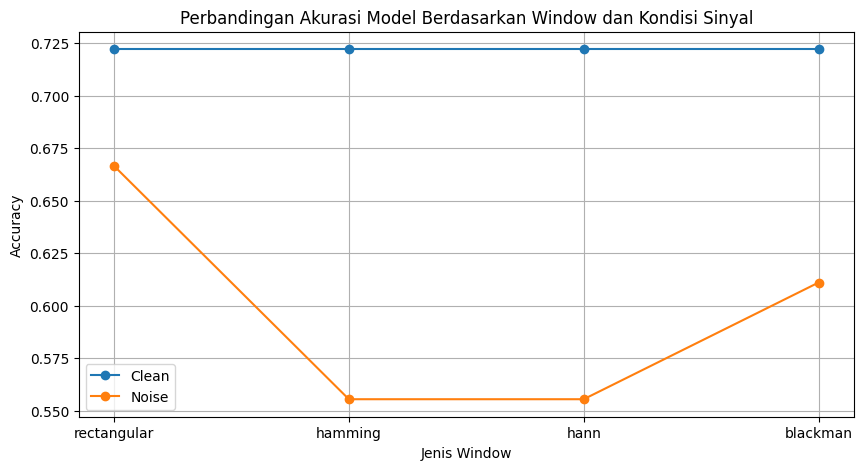

In [30]:
plt.figure(figsize=(10,5))

for cond in ["Clean", "Noise"]:
    subset = df_all[df_all["condition"] == cond]
    plt.plot(subset["window"], subset["accuracy"], marker='o', label=cond) #plot akurasi berdasarkan window

plt.title("Perbandingan Akurasi Model Berdasarkan Window dan Kondisi Sinyal")
plt.xlabel("Jenis Window")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

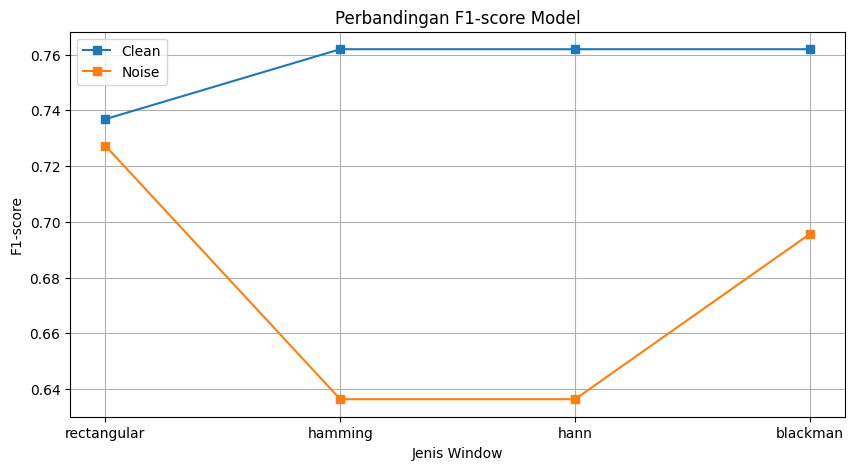

In [31]:
plt.figure(figsize=(10,5))

for cond in ["Clean", "Noise"]:
    subset = df_all[df_all["condition"] == cond]
    plt.plot(subset["window"], subset["f1"], marker='s', label=cond) #plot berdasarkan f1-score

plt.title("Perbandingan F1-score Model")
plt.xlabel("Jenis Window")
plt.ylabel("F1-score")
plt.legend()
plt.grid(True)
plt.show()

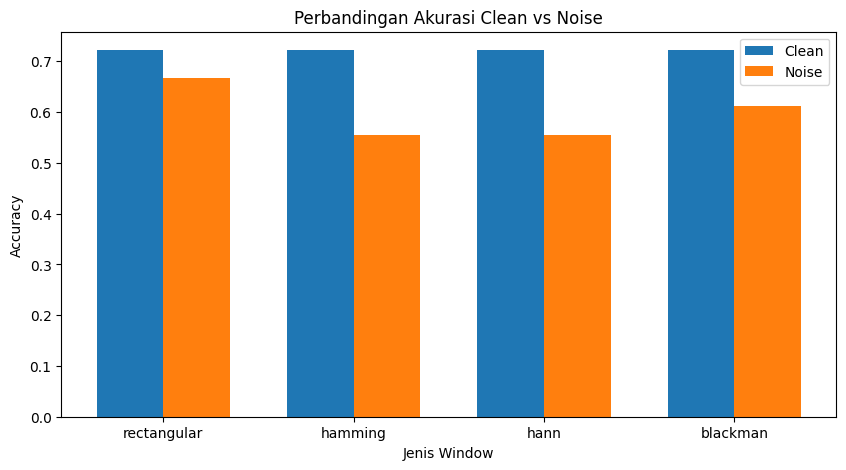

In [32]:
plt.figure(figsize=(10,5))

x = np.arange(len(WINDOW_LIST))
width = 0.35

clean_acc = df_clean["accuracy"].values
noise_acc = df_noise["accuracy"].values

plt.bar(x - width/2, clean_acc, width, label="Clean") #bar chart akurasi clean
plt.bar(x + width/2, noise_acc, width, label="Noise") #bar chart akurasi gaussian noise

plt.xticks(x, WINDOW_LIST)
plt.xlabel("Jenis Window")
plt.ylabel("Accuracy")
plt.title("Perbandingan Akurasi Clean vs Noise")
plt.legend()
plt.show()